# CNN Model Implementation

### Four Layer 2D convolutional network implementation.
### Model selcted after comparing its performence against three layer CNN model.
### Without Data Augmentation and feature engineering the model achieved 58% accuracy.

For efficient train, validation, & test set creation and also for model traning (balanced and well distributed data processing) I adopted the implementation method proposed by "Ilia Zenkov". 

Mel-spectrogram values corresponding to each audio samples are extracted and used it as training feature.

Audio time scale is set as width and set freequency as height,

Extracted features are changed into 4D tensor after adding sigle channel dimension with each audio mel spectrogram matrix.

Selected CNN model as a base line model because of its ability to learn from spatial feature representation.

By doing so we can comapre the model performance of CNN against hybrid parallel CNN-Transformer model

#### ConvNet - Model Architecture Details :
      
  CNN BLOCK 1 ===================================
  
    Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    BatchNorm2d(16, eps=1e-05, momentum=0.1)
    ReLU()
    MaxPool2d(kernel_size=2, stride=2, padding=0)
    Dropout(p=0.3)
    
  CNN BLOCK 2 ===================================
  
    Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    BatchNorm2d(32, eps=1e-05, momentum=0.1)
    ReLU()
    MaxPool2d(kernel_size=4, stride=4, padding=0)
    Dropout(p=0.3)
    
  CNN BLOCK 3 ===================================
  
    Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    BatchNorm2d(64, eps=1e-05, momentum=0.1)
    ReLU()
    MaxPool2d(kernel_size=4, stride=4, padding=0)
    Dropout(p=0.3)
    
  CNN BLOCK 4 ===================================
  
    Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    BatchNorm2d(64, eps=1e-05, momentum=0.1)
    ReLU()
    MaxPool2d(kernel_size=4, stride=4, padding=0)
    Dropout(p=0.3)

In [1]:
# loading data processing and visualization packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings("ignore")

In [2]:
# loading deep learning Pytorch and librosa audio library
import torch
import torchaudio
import torch.nn as nn
import librosa
import librosa.display
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchsummary import summary

In [3]:
# Read the saved label data from CSV file to data frame
signal_data = pd.read_csv('data.csv')
signal_data.head()

,Path,Emotion,Emotion_intensity,Gender
0,./archive/Actor_01/03-01-01-01-01-01-01.wav,1,1,male
1,./archive/Actor_01/03-01-01-01-01-02-01.wav,1,1,male
2,./archive/Actor_01/03-01-01-01-02-01-01.wav,1,1,male
3,./archive/Actor_01/03-01-01-01-02-02-01.wav,1,1,male
4,./archive/Actor_01/03-01-02-01-01-01-01.wav,2,1,male


In [4]:
# creating copy of the data frame
myDataFrame=signal_data
myDataFrame.set_index('Path')

,Emotion,Emotion_intensity,Gender
Path,,,
./archive/Actor_01/03-01-01-01-01-01-01.wav,1,1,male
./archive/Actor_01/03-01-01-01-01-02-01.wav,1,1,male
./archive/Actor_01/03-01-01-01-02-01-01.wav,1,1,male
./archive/Actor_01/03-01-01-01-02-02-01.wav,1,1,male
./archive/Actor_01/03-01-02-01-01-01-01.wav,2,1,male
...,...,...,...
./archive/Actor_24/03-01-08-01-02-02-24.wav,0,1,female
./archive/Actor_24/03-01-08-02-01-01-24.wav,0,2,female
./archive/Actor_24/03-01-08-02-01-02-24.wav,0,2,female


In [5]:
# assiging the sample rate to a variable that find out using librosa
sample_rate = 48000

# funtion that return the extracted features
def extract_features(waveforms, features, samplerate):

    # counter to track file processing
    file_count = 0
    #wave_lenght = len(waveforms)
    # process each waveform individually to get its mel-spectrogram data
    for waveform in waveforms:
        mel_spec = extract_melspectrogram(waveform, sample_rate)
        features.append(mel_spec)
        file_count += 1
        
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
        
    
    # return all features from list of waveforms
    return features

# funtion to extrac audio in signal format
def load_waveforms(file):
    # read the full 3 seconds of the file, cut off the first 0.5s of silence
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    
    # making each vectors homogenious in nature
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    # return file's waveform                                      
    return waveform_homo

# function to compute mel spectrogram values corresponding to each audio signal.
def extract_melspectrogram(audio, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms 
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [6]:
# extracting and storing each wave form vector
waveforms  = []
# counter to track file processing
file_count = 0
for file in signal_data.Path:
    waveform = load_waveforms(file)
    waveforms.append(waveform)
    file_count += 1
    print('\r'+f' Processed {file_count}/{len(signal_data)} waveforms',end='')
    
# verify the wave form stored
print('\n')
print(len(waveforms))
print(len(waveforms[0]))
print(type(waveforms))

 Processed 1440/1440 waveforms

1440
144000
<class 'list'>


In [7]:
# convert the list into numpy multi-dimentional array for test train split.
# convert waveforms to array for processing
signals = np.stack(waveforms,axis=0)
print(signals.ndim)
print(signals.shape)
print(type(signals))

2
(1440, 144000)
<class 'numpy.ndarray'>


# ===========================================================

In [8]:
# Create a dictionary and set surprised = 0 insted of 8  for PyTorch
EMOTIONS ={
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'
}

In [9]:
# initialize empty list for train, validation, test sets and their indices
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]

In [10]:
# process each emotion separately to make sure we builf balanced train/valid/test sets
for emotion in range(len(EMOTIONS)):
    # Extract and store all indices corrsponding to individual emotion seperately - ie one emotion per iteration
    emotion_ind = list(signal_data.loc[signal_data.Emotion==emotion,'Emotion'].index)
    # seed and shuffle indicies 
    emotion_ind = np.random.permutation(emotion_ind)
    # Assign length of the emotion list to make indices
    m = len(emotion_ind)
    
    # store indices of training, validation and test sets in 80/10/10 proportion - train set is first 80%
    ind_train = emotion_ind[:int(0.8*m)]
    # validation set is next 10% (between 80% and 90%)
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    # test set is last 10% (between 90% - end/100%)
    ind_test = emotion_ind[int(0.9*m):]
    
     # create train waveforms/labels sets
    X_train.append(signals[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    # create validation waveforms/labels sets
    X_val.append(signals[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(signals[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    
    # store indices for each emotion set to verify uniqueness between sets
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
    
# concatenate, in order, all waveforms back into one array     
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)

# print shape of each set
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

X_train:(1147, 144000), Y_train:(1147,)
X_val:(143, 144000), Y_val:(143,)
X_test:(150, 144000), Y_test:(150,)


## Feature Extraction

In [11]:
# initialize feature arrays
# Extract Mel-spectrogram features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features 
features_train = extract_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = extract_features(X_val, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features 
features_test = extract_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (Mel-Spectrogram matrix) shape: {len(features_train[0])} x {len(features_train[0][1])}')

Train waveforms:
 Processed 1147/1147 waveforms

Validation waveforms:
 Processed 143/143 waveforms

Test waveforms:
 Processed 150/150 waveforms

Features set: 1440 total, 1147 train, 143 validation, 150 test samples
Features (Mel-Spectrogram matrix) shape: 128 x 563


In [12]:
# Convert each list into numpy array for pytorch and stored them in corresponding train arrays
features_train = np.stack(features_train,axis=0)
features_valid = np.stack(features_valid,axis=0)
features_test = np.stack(features_test,axis=0)

In [13]:
print(type(features_train))
print(len(features_train))

<class 'numpy.ndarray'>
1147


In [14]:
"""
Here we have 1 signal intensity channel, because we are using gray scale signal representation,
to feed the data in to a 2D convolutional network in pytorch we need to define a 4D Tensor Array
We need an input channel dim to expand to output channels using CNN filters. 
We create a dummy channel dim ie 1 to expand features into 2D-CNN-ready 4D tensor format: N x C x H x W.
"""

# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(features_train,1)
X_val = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with 
y_train = np.array(Y_train)
y_val = np.array(Y_val)
y_test = np.array(Y_test)

In [15]:
print(type(X_train))

<class 'numpy.ndarray'>


In [16]:
#Print (batch, channel, width, height)
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_val:{X_val.shape}, y_val:{y_val.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}')

X_train:(1147, 1, 128, 563), y_train:(1147,)
X_val:(143, 1, 128, 563), y_val:(143,)
X_test:(150, 1, 128, 563), y_test:(150,)


## Model Definition

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv2Dblock = nn.Sequential(
            # First convolutional layer   (input : 1x128x563)
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            # First convolutional pooling layer
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # Second convolutional layer  (input : 16x64x281)
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            # Second convolutional pooling layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # Third convolutional layer  (input : 32x16x70)
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            # Third convolutional pooling layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # Fourth convolutional layer  (input : 64x4x17)
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            # Fourth convolutional layer  (input : 64x4x17)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        """
        input in to the Linear block (64x1x4 = 256, number of emotions = 8)
        Each full convolution block outputs (64*1*4) embedding flattened to dim 256 1D array
        from 256 input feature create 8 output imotions (256 ==> 8)
        """
        # Linear softmax layer will take final signal embedded tensor 
        self.out_linear = nn.Linear(256,8)
        self.dropout_linear = nn.Dropout(p=0)
        # Softmax layer for the 8 output logits from final FC linear layer 
        self.out_softmax = nn.Softmax(dim=1)
    def forward(self,x):
        # forward pass of input feature tensor
        # create final feature embedding from 2D convolutional sequence block 
        # input features pased through 4 sequential 2D convolutional layers
        signal_embedding = self.conv2Dblock(x)
        
        # flatten final 64*1*4 feature map from convolutional layers to length 256 1D array 
        # skip the 1st minibatch dimension when flattening ie start_dim=1
        conv_embedding = torch.flatten(signal_embedding, start_dim=1)
        
        # final fully connected linear layer, need logits for loss calculation
        output_logits = self.out_linear(conv_embedding)
        output_logits = self.dropout_linear(output_logits)
        
        # final Softmax layer for prediction
        output_softmax = self.out_softmax(output_logits)
        
        return output_logits, output_softmax

In [18]:
"""
Checking the model architectue based on temporary defined optimizer and loss fuction
"""
# instantiate the model
model = ConvNet()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ConvNet(
  (conv2Dblock): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.3, inplace=False)
    (15): Conv2d(64, 64, kernel_size=(3, 3), stri

In [19]:
# model summary based on input feature shape.
summary(model, input_size=(1,128,563))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 563]             160
       BatchNorm2d-2         [-1, 16, 128, 563]              32
              ReLU-3         [-1, 16, 128, 563]               0
         MaxPool2d-4          [-1, 16, 64, 281]               0
           Dropout-5          [-1, 16, 64, 281]               0
            Conv2d-6          [-1, 32, 64, 281]           4,640
       BatchNorm2d-7          [-1, 32, 64, 281]              64
              ReLU-8          [-1, 32, 64, 281]               0
         MaxPool2d-9           [-1, 32, 16, 70]               0
          Dropout-10           [-1, 32, 16, 70]               0
           Conv2d-11           [-1, 64, 16, 70]          18,496
      BatchNorm2d-12           [-1, 64, 16, 70]             128
             ReLU-13           [-1, 64, 16, 70]               0
        MaxPool2d-14            [-1, 64

In [20]:
#  loss function for the backwards pass of each training iteration
#  We use log softmax for faster gradient optimization.
def loss_function(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [21]:
# function to create a single step of the each iteration training phase
def train_step_function(model, loss_function, optimizer):
    # training step of the training phase
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass and output_logits, output_softmax values are returned
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss and defining back propagation
        loss = loss_function(output_logits, Y)
         # compute gradients for the optimizer to use 
        loss.backward()
        # update network parameters based on gradient stored
        optimizer.step()
        # zero out gradients for next pass (ie accumulates gradients from backwards passe)
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [22]:
# define the validation function for each iteration on validation mini batches
def validation_step_function(model,loss_function):  
    def validate(X,Y):
        # use to save memory and compute in validation phase:
        with torch.no_grad():
            # initialize model for validation phase by turning off dropout and batchnorm layers
            model.eval()
            # compute model predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            # compute error
            loss = loss_function(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [23]:
# set epoch size
EPOCHS=700
# read and assign train set lenght to variable DATASET_SIZE for define the number of iterations
DATASET_SIZE = X_train.shape[0]
# set batch size
BATCH_SIZE = 32
# set computation device as CUDA if available or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
# Initialize the model in Selected device
model = ConvNet().to(device)
# set SGD as optimizer
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)
# call the training step function 
train_step = train_step_function(model, loss_function, optimizer=OPTIMIZER)
# Call the validation function
validate = validation_step_function(model,loss_function)
# define empty lists to store scalar performance metrics for ploating
losses=[]
val_losses = []

Selected device is cuda


In [24]:
# created a function for training each individual epoches loop for entire training set
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):
    for epoch in range(EPOCHS):
        
        # schuffle data to randomize minibatch order
        ind = np.random.permutation(DATASET_SIZE)
        
        # shuffle the training set for each epoch:
        X_train = X_train[ind,:,:,:]
        Y_train = Y_train[ind]
        
        epoch_acc = 0
        epoch_loss = 0
        
        # Define number of iterations per epoch to process the entire train set
        iters = int(DATASET_SIZE / BATCH_SIZE)
         # create a loop for each minibatch of 32 samples:
        for i in range(iters):
            # track and update minibatch position based on iteration number to make sure all all data in the samples processd
            batch_start = i * BATCH_SIZE
            # Define bounds of our training set
            batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start
            # set training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:]
            # Set training minibatch labels 
            Y = Y_train[batch_start:batch_end]
            
            # Convert the train set and lables in to torch tensor format- train in to tensor flot and lables into long double
            X_tensor = torch.tensor(X,device=device).float()
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
             # Call the training function and train the model on train set features and lablels for each minibaches
            loss, acc = train_step(X_tensor,Y_tensor)
            
            # Keep track of loss and accuracy chage by aggrigating in to the variable for  measure the training and validation
            epoch_acc += acc*actual_batch_size/DATASET_SIZE
            epoch_loss += loss*actual_batch_size/DATASET_SIZE
            
            # Print details iteration wise training progress
            print(f"\r Epoch {epoch}: iteration {i+1}/{iters}",end='')
            
        # create tensors from validation set
        X_val_tensor = torch.tensor(X_valid,device=device).float()
        Y_val_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # call validation function and keep track of validation set performance
        val_loss, val_acc, predictions = validate(X_val_tensor,Y_val_tensor)
        
        # append scalar performance metrics at each epoch to track and plot later
        losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        print('')
        print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")

In [25]:
# call the train function and train the model
train(OPTIMIZER, model, EPOCHS, X_train, y_train, X_val, y_val)

 Epoch 0: iteration 35/35
Epoch 0 --> loss:2.4196, acc:16.13%, val_loss:2.1253, val_acc:16.08%
 Epoch 1: iteration 35/35
Epoch 1 --> loss:2.0603, acc:21.53%, val_loss:2.1411, val_acc:13.29%
 Epoch 2: iteration 35/35
Epoch 2 --> loss:2.0062, acc:22.49%, val_loss:2.1043, val_acc:13.29%
 Epoch 3: iteration 35/35
Epoch 3 --> loss:1.9047, acc:24.06%, val_loss:2.0979, val_acc:13.29%
 Epoch 4: iteration 35/35
Epoch 4 --> loss:1.8277, acc:29.21%, val_loss:2.3950, val_acc:23.08%
 Epoch 5: iteration 35/35
Epoch 5 --> loss:1.7661, acc:31.73%, val_loss:2.8656, val_acc:15.38%
 Epoch 6: iteration 35/35
Epoch 6 --> loss:1.6998, acc:33.83%, val_loss:3.3918, val_acc:13.29%
 Epoch 7: iteration 35/35
Epoch 7 --> loss:1.7178, acc:32.61%, val_loss:2.8368, val_acc:26.57%
 Epoch 8: iteration 35/35
Epoch 8 --> loss:1.6616, acc:34.09%, val_loss:3.1859, val_acc:23.08%
 Epoch 9: iteration 35/35
Epoch 9 --> loss:1.6579, acc:36.09%, val_loss:3.3788, val_acc:24.48%
 Epoch 10: iteration 35/35
Epoch 10 --> loss:1.643

 Epoch 85: iteration 35/35
Epoch 85 --> loss:1.0003, acc:59.46%, val_loss:1.9569, val_acc:31.47%
 Epoch 86: iteration 35/35
Epoch 86 --> loss:0.9947, acc:60.51%, val_loss:1.6721, val_acc:40.56%
 Epoch 87: iteration 35/35
Epoch 87 --> loss:0.9465, acc:64.69%, val_loss:2.0894, val_acc:30.77%
 Epoch 88: iteration 35/35
Epoch 88 --> loss:0.9572, acc:63.30%, val_loss:2.2593, val_acc:22.38%
 Epoch 89: iteration 35/35
Epoch 89 --> loss:0.9465, acc:63.30%, val_loss:2.1585, val_acc:28.67%
 Epoch 90: iteration 35/35
Epoch 90 --> loss:0.9918, acc:59.37%, val_loss:2.2389, val_acc:30.07%
 Epoch 91: iteration 35/35
Epoch 91 --> loss:0.9322, acc:63.99%, val_loss:2.2488, val_acc:26.57%
 Epoch 92: iteration 35/35
Epoch 92 --> loss:0.9667, acc:63.64%, val_loss:1.8022, val_acc:32.17%
 Epoch 93: iteration 35/35
Epoch 93 --> loss:0.9533, acc:61.90%, val_loss:1.9593, val_acc:32.87%
 Epoch 94: iteration 35/35
Epoch 94 --> loss:0.9344, acc:63.03%, val_loss:1.7626, val_acc:39.16%
 Epoch 95: iteration 35/35
Epo

 Epoch 251: iteration 35/35
Epoch 251 --> loss:0.3727, acc:83.96%, val_loss:1.3408, val_acc:53.85%
 Epoch 252: iteration 35/35
Epoch 252 --> loss:0.3803, acc:85.00%, val_loss:1.2911, val_acc:51.05%
 Epoch 253: iteration 35/35
Epoch 253 --> loss:0.3828, acc:83.96%, val_loss:1.4135, val_acc:49.65%
 Epoch 254: iteration 35/35
Epoch 254 --> loss:0.3953, acc:82.56%, val_loss:1.4134, val_acc:51.75%
 Epoch 255: iteration 35/35
Epoch 255 --> loss:0.3919, acc:84.39%, val_loss:1.4804, val_acc:50.35%
 Epoch 256: iteration 35/35
Epoch 256 --> loss:0.3661, acc:84.92%, val_loss:1.4998, val_acc:51.05%
 Epoch 257: iteration 35/35
Epoch 257 --> loss:0.3795, acc:84.39%, val_loss:1.4296, val_acc:52.45%
 Epoch 258: iteration 35/35
Epoch 258 --> loss:0.3441, acc:85.79%, val_loss:1.6778, val_acc:47.55%
 Epoch 259: iteration 35/35
Epoch 259 --> loss:0.3950, acc:83.44%, val_loss:1.3368, val_acc:54.55%
 Epoch 260: iteration 35/35
Epoch 260 --> loss:0.3885, acc:84.31%, val_loss:1.4226, val_acc:51.05%
 Epoch 261

 Epoch 334: iteration 35/35
Epoch 334 --> loss:0.2651, acc:87.88%, val_loss:1.3255, val_acc:55.94%
 Epoch 335: iteration 35/35
Epoch 335 --> loss:0.2780, acc:88.14%, val_loss:1.2759, val_acc:56.64%
 Epoch 336: iteration 35/35
Epoch 336 --> loss:0.3147, acc:86.31%, val_loss:1.3332, val_acc:52.45%
 Epoch 337: iteration 35/35
Epoch 337 --> loss:0.2757, acc:88.75%, val_loss:1.4364, val_acc:51.75%
 Epoch 338: iteration 35/35
Epoch 338 --> loss:0.3040, acc:87.01%, val_loss:1.4045, val_acc:51.05%
 Epoch 339: iteration 35/35
Epoch 339 --> loss:0.2966, acc:87.36%, val_loss:1.0635, val_acc:60.84%
 Epoch 340: iteration 35/35
Epoch 340 --> loss:0.2777, acc:88.32%, val_loss:1.3765, val_acc:55.94%
 Epoch 341: iteration 35/35
Epoch 341 --> loss:0.2633, acc:89.01%, val_loss:1.3007, val_acc:60.14%
 Epoch 342: iteration 35/35
Epoch 342 --> loss:0.2970, acc:87.36%, val_loss:1.0981, val_acc:60.84%
 Epoch 343: iteration 35/35
Epoch 343 --> loss:0.2673, acc:88.67%, val_loss:1.3670, val_acc:53.15%
 Epoch 344

 Epoch 417: iteration 35/35
Epoch 417 --> loss:0.2828, acc:87.45%, val_loss:1.1627, val_acc:56.64%
 Epoch 418: iteration 35/35
Epoch 418 --> loss:0.2679, acc:88.84%, val_loss:1.1810, val_acc:56.64%
 Epoch 419: iteration 35/35
Epoch 419 --> loss:0.2319, acc:90.24%, val_loss:1.3878, val_acc:53.15%
 Epoch 420: iteration 35/35
Epoch 420 --> loss:0.2244, acc:90.06%, val_loss:1.1103, val_acc:62.24%
 Epoch 421: iteration 35/35
Epoch 421 --> loss:0.2384, acc:89.97%, val_loss:1.4926, val_acc:47.55%
 Epoch 422: iteration 35/35
Epoch 422 --> loss:0.2271, acc:90.24%, val_loss:1.3144, val_acc:58.74%
 Epoch 423: iteration 35/35
Epoch 423 --> loss:0.2195, acc:90.15%, val_loss:1.4877, val_acc:51.75%
 Epoch 424: iteration 35/35
Epoch 424 --> loss:0.2115, acc:90.58%, val_loss:1.1720, val_acc:60.84%
 Epoch 425: iteration 35/35
Epoch 425 --> loss:0.2104, acc:90.24%, val_loss:1.3800, val_acc:53.85%
 Epoch 426: iteration 35/35
Epoch 426 --> loss:0.2395, acc:89.10%, val_loss:1.4873, val_acc:54.55%
 Epoch 427

 Epoch 500: iteration 35/35
Epoch 500 --> loss:0.2032, acc:90.58%, val_loss:1.4809, val_acc:53.15%
 Epoch 501: iteration 35/35
Epoch 501 --> loss:0.2163, acc:89.97%, val_loss:1.1957, val_acc:60.14%
 Epoch 502: iteration 35/35
Epoch 502 --> loss:0.2356, acc:89.80%, val_loss:1.2381, val_acc:62.24%
 Epoch 503: iteration 35/35
Epoch 503 --> loss:0.2218, acc:90.15%, val_loss:1.1932, val_acc:57.34%
 Epoch 504: iteration 35/35
Epoch 504 --> loss:0.1837, acc:91.63%, val_loss:1.1760, val_acc:65.73%
 Epoch 505: iteration 35/35
Epoch 505 --> loss:0.2338, acc:90.06%, val_loss:1.4063, val_acc:55.94%
 Epoch 506: iteration 35/35
Epoch 506 --> loss:0.1751, acc:92.07%, val_loss:1.4052, val_acc:58.04%
 Epoch 507: iteration 35/35
Epoch 507 --> loss:0.2010, acc:89.97%, val_loss:1.2245, val_acc:58.04%
 Epoch 508: iteration 35/35
Epoch 508 --> loss:0.2163, acc:90.93%, val_loss:1.3686, val_acc:58.74%
 Epoch 509: iteration 35/35
Epoch 509 --> loss:0.1928, acc:91.11%, val_loss:0.9926, val_acc:58.74%
 Epoch 510

 Epoch 583: iteration 35/35
Epoch 583 --> loss:0.1906, acc:91.02%, val_loss:0.9910, val_acc:64.34%
 Epoch 584: iteration 35/35
Epoch 584 --> loss:0.1978, acc:91.02%, val_loss:1.1298, val_acc:62.24%
 Epoch 585: iteration 35/35
Epoch 585 --> loss:0.2025, acc:91.02%, val_loss:1.0421, val_acc:68.53%
 Epoch 586: iteration 35/35
Epoch 586 --> loss:0.2186, acc:90.58%, val_loss:1.4100, val_acc:55.94%
 Epoch 587: iteration 35/35
Epoch 587 --> loss:0.2506, acc:89.01%, val_loss:1.0409, val_acc:60.84%
 Epoch 588: iteration 35/35
Epoch 588 --> loss:0.2053, acc:90.76%, val_loss:1.2224, val_acc:55.24%
 Epoch 589: iteration 35/35
Epoch 589 --> loss:0.1954, acc:90.85%, val_loss:1.3096, val_acc:58.04%
 Epoch 590: iteration 35/35
Epoch 590 --> loss:0.2102, acc:91.19%, val_loss:1.2195, val_acc:58.04%
 Epoch 591: iteration 35/35
Epoch 591 --> loss:0.1804, acc:91.89%, val_loss:1.0747, val_acc:60.14%
 Epoch 592: iteration 35/35
Epoch 592 --> loss:0.1545, acc:93.37%, val_loss:1.2542, val_acc:58.04%
 Epoch 593

 Epoch 666: iteration 35/35
Epoch 666 --> loss:0.1904, acc:91.28%, val_loss:1.2486, val_acc:56.64%
 Epoch 667: iteration 35/35
Epoch 667 --> loss:0.1930, acc:91.54%, val_loss:1.1319, val_acc:63.64%
 Epoch 668: iteration 35/35
Epoch 668 --> loss:0.1902, acc:91.02%, val_loss:1.2950, val_acc:62.24%
 Epoch 669: iteration 35/35
Epoch 669 --> loss:0.1612, acc:93.55%, val_loss:1.0775, val_acc:62.24%
 Epoch 670: iteration 35/35
Epoch 670 --> loss:0.2032, acc:90.32%, val_loss:1.4630, val_acc:55.94%
 Epoch 671: iteration 35/35
Epoch 671 --> loss:0.1787, acc:92.07%, val_loss:1.2221, val_acc:62.94%
 Epoch 672: iteration 35/35
Epoch 672 --> loss:0.1621, acc:91.72%, val_loss:1.0442, val_acc:65.03%
 Epoch 673: iteration 35/35
Epoch 673 --> loss:0.1785, acc:91.89%, val_loss:1.2308, val_acc:55.94%
 Epoch 674: iteration 35/35
Epoch 674 --> loss:0.1968, acc:91.11%, val_loss:1.5950, val_acc:53.85%
 Epoch 675: iteration 35/35
Epoch 675 --> loss:0.1572, acc:92.94%, val_loss:1.2631, val_acc:58.74%
 Epoch 676

### Loss Curve

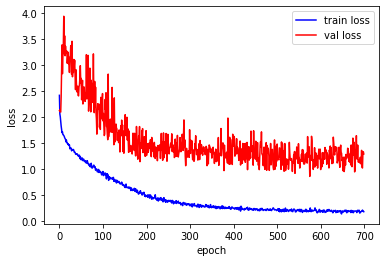

In [26]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train loss','val loss'])

### Evaluate the Model on test set

In [27]:
# Convert 4D test set and label set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)

# Get the model's performance metrics using the validation function initialized before
test_loss, test_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.277
Test accuracy is 57.33%


In [28]:
print(type(predictions))
print(len(predictions))
print(predictions)

<class 'torch.Tensor'>
150
tensor([7, 7, 0, 0, 0, 2, 0, 0, 6, 6, 7, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 2, 1, 0,
        7, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 6, 5, 6, 5, 6, 0, 3, 6, 0, 2, 4, 7, 5, 7, 5, 5, 7, 0, 3, 6, 2, 2,
        2, 7, 6, 6, 4, 4, 7, 7, 0, 4, 2, 2, 6, 2, 2, 2, 4, 2, 5, 5, 0, 5, 5, 5,
        6, 5, 5, 5, 6, 5, 5, 7, 5, 5, 5, 5, 7, 0, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6,
        0, 6, 6, 6, 6, 6, 6, 0, 6, 6, 2, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 7, 4, 7,
        7, 2, 7, 7, 7, 7], device='cuda:0')


### confusion matrix

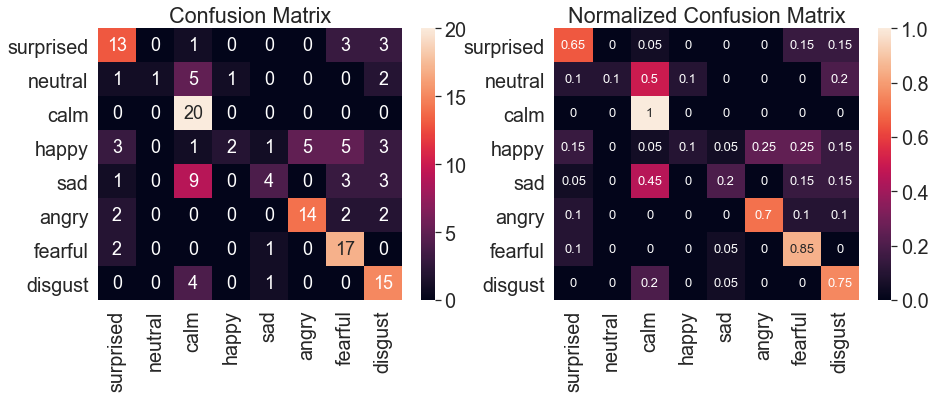

In [29]:
# build confusion matrix and normalized confusion matrix
predictions = predictions.cpu().numpy()
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix_norm = confusion_matrix(y_test, predictions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = [emotion for emotion in EMOTIONS.values()]

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(15,5))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [30]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_base_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_base_model.pt')))

Model is saved to C:\Users\janakishyama\Desktop\ESR06\Implementation\my_model\models\cnn_base_model.pt
